In [ ]:
## 제8절 시계열분석
# 1. 시계열 분해
# 시계열 분해는 시계열 자료를 추세, 계절성, 잔차로 분해하는 기법이다.
# 시간의 요인은 추세, 계절성이며 외부요인은 잔차(불규칙요인)이 있다.
# (1) 모형 판단
# 시계열 데이터를 보고 시계열의 주기적 반속/계정설이 있는지에 따라 Additive 모형과 Multhplicative 모형 중 어떤 모형이 더 적합할지 판단한다.
# 추세와 계절성이 별개로 존재한다면 Additive 모형을 선택하고 추세에 따라 계절성이 잇다면 Multhplicative 모형을 적용한다.

In [23]:
import pandas as pd
import warnings

data = pd.read_csv('C:/Users/A202112006/Desktop/py/data/arima_data.csv', names = ['day', 'price'])
data.head()

,day,price
0,2013-01-01,3794
1,2013-02-01,3863
2,2013-03-01,5190
3,2013-04-01,5783
4,2013-05-01,6298


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     60 non-null     object
 1   price   60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [25]:
data['day'] = pd.to_datetime(data['day'], format="%Y-%m-%d")
data.set_index('day', inplace=True)
data.head(3)

,price
day,
2013-01-01,3794
2013-02-01,3863
2013-03-01,5190


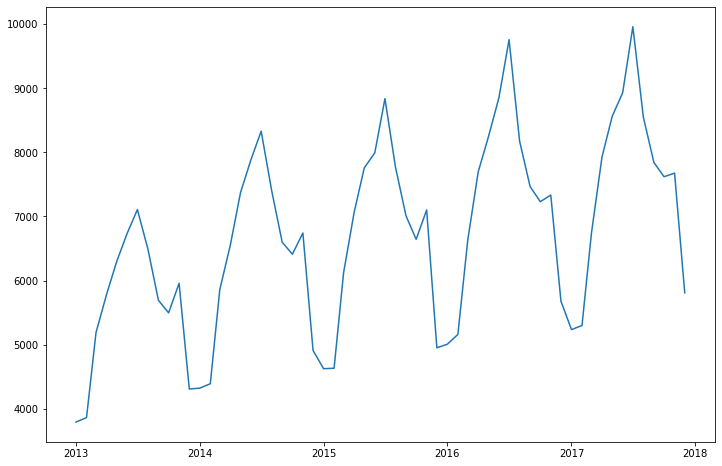

In [26]:
import matplotlib.pyplot as plt
plt.plot(data.index, data['price'])

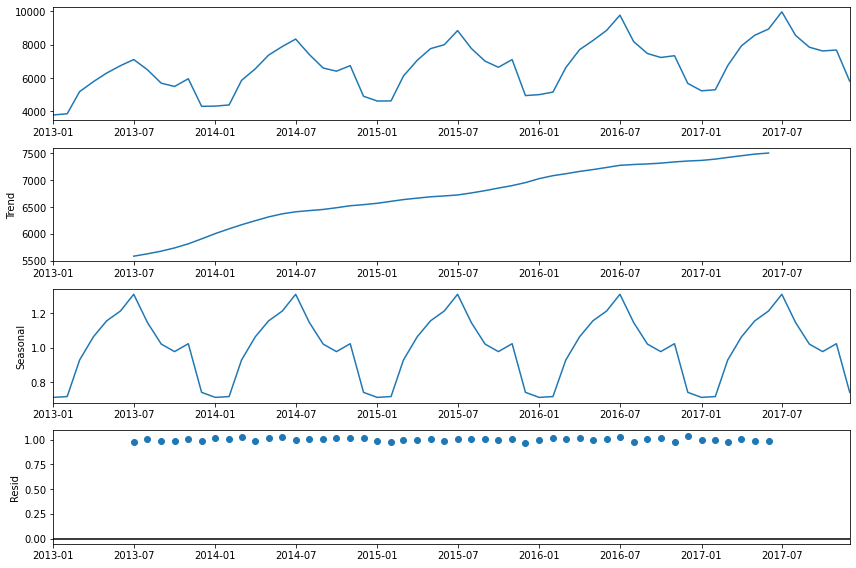

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = data
result = seasonal_decompose(ts, model='multiplicative')
plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()

In [28]:
## 2. 정상성 변환
# (1) 개념
#  - 정상성이란 평균, 분산이 시간에 따라 일정한 성질을 가지고 있다는 것이다.
#    즉, 시계열 데이터의 특성이 시간의 흐름에 따라 변하지 않는 상태를 의미한다. 

In [29]:
from statsmodels.tsa.stattools import adfuller

# Train, Test 데이터 구분
training = data[:"2016-12-01"]
test = data.drop(training.index)

## Augmented Dickey-Fuller Test 가설
# 대립가설(H0) : 데이터가 정상성을 갖지 않는다.
# 귀무가설(H1) : 데이터가 정상성을 갖는다.
adf = adfuller(training, regression = 'ct')
print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))
# 대리가설을 채택하므로 데이터가 정상성을 갖지 않음.

ADF Statistic: -1.9997199341328045
p-value : 0.6015863303794045


<AxesSubplot: xlabel='day'>

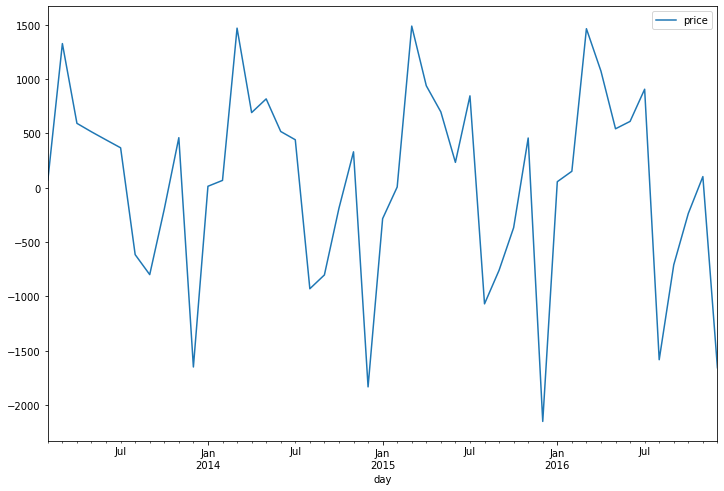

In [30]:
# 차분
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_data = training.diff(1)
diff_data = diff_data.dropna()
diff_data.plot()

In [31]:
adf = adfuller(diff_data)
print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))
# 차분 후에는 정상성을 가짐

ADF Statistic: -12.094547576926418
p-value : 2.085160639961112e-22


In [32]:
## 3. AR 모형과 MA 모형
# ARIMA 모형의 가정인 정상성에 대해서 알았다면 AR 모형과 MA 모형의 특징을 알아보자.

## (1) AR 
#  - 개념 : AR모형은 자기회귀과정이란 뜻으로 현 시점의 데이터를 이전의 데이터들의 상관성으로 나타내는 모형이다.
#     즉, 과거의 값이 현재의 값에 얼마나 영향을 미쳤는지를 파악하는 것이다.
#     만약 과거의 값이 현재의 값에 영향을 미치지 않는다면 해당 모형의 성능은 낮아진다.
#     이때, 최적의 성능을 가지는 모델을 만들 수 있는 과거의 값을 찾게 되는데, 이 값을 p라고 하며 AR(p) 모형이라고 한다.
#  - ACF
#   ACF는 자기상관 함수로 이 값은 시차에 따른 자기상관성을 의미한다. ACF 값을 시차에 따른 그래프로 시각화 해보면, 최적의 p값을 찾을 수 있다.
#   비정상 시계열일 경우에는 ACF값은 느리게 0에 접근하며, 양수의 값을 가질 수도 있다.
#   하지만 정상 시계열일 경우에는 ACF 값이 빠르게 0으로 수렴하며 0으로 수렴할 때에 시차를 p값으로 설정한다.

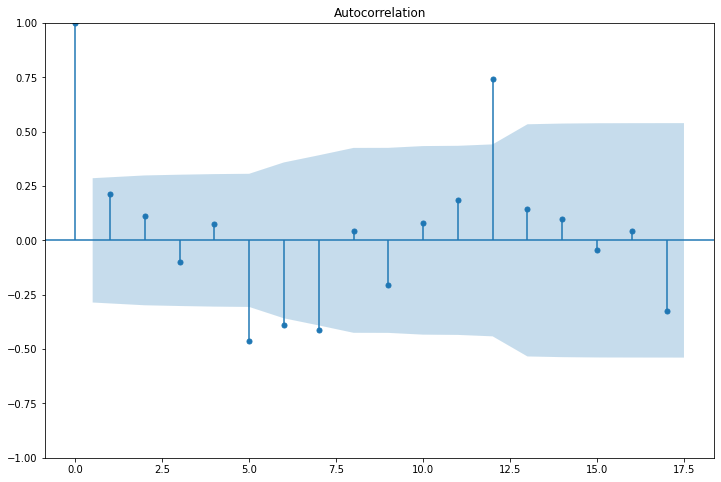

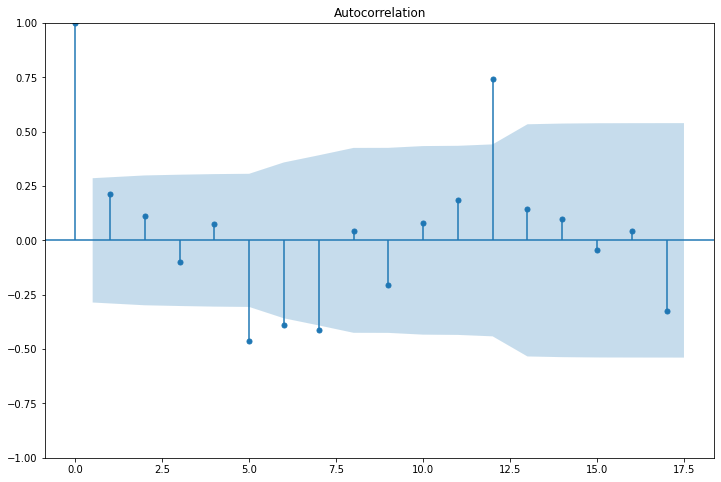

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(diff_data) #AR(p)의 값 확인 가능

c:\Program Files\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


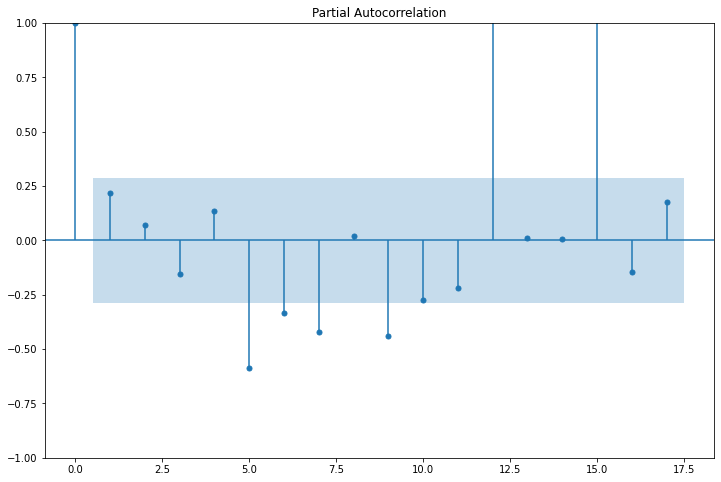

In [34]:
## (2) MA
#  - 개념 : MA 모형은 과거의 예측 오차들의 가중이동편균으로 현재 시점의 데이터를 표현하는 모형이다.
#   즉, 과거의 예측 오차를 이용하여 미래를 예측하는 모형이라고도 할 수 있다.
#   과거의 예측 오차들에 따라서 가중이동편균은 달라진다. 그렇기에 MA 모형은 최적의 모형이 되는 구간을 구하는것이 중요하다.
#   MA 모형이 최적이 되게끔 하는 변수 값이 q이며 이 모형을 MA(q) 모형이라 한다.
#  - PACF
#   PACF는 편자기상관 함수이다. PACF는 ACF와는 다르게 시차가 다른 두 시계열 데이터간의 순수한 상호 연관성을 나타낸다.
#   그러므로 PACF 값이 0에 수렴할 때의 q값을 MA모형의 q값으로 설정한다.

plot_pacf(diff_data) #MA(q)의 값 확인 가능

plt.show()

In [35]:
## 4. ARIMA
#  - p : ACF , d : 차분의 횟수 , q : PACF

In [36]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(training, order=(2,1,2), trend='ct')
res = model.fit()
res.summary()

c:\Program Files\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ValueError: In models with integration (`d > 0`) or seasonal integration (`D > 0`), trend terms of lower order than `d + D` cannot be (as they would be eliminated due to the differencing operation). For example, a constant cannot be included in an ARIMA(1, 1, 1) model, but including a linear trend, which would have the same effect as fitting a constant to the differenced data, is allowed.

In [37]:
plt.plot(res.predict())
plt.plot(training)

NameError: name 'res' is not defined

In [13]:
forecast_data = res.forecast(steps=len(test), alpha=0.05) 
# 학습 데이터셋으로부터 test 데이터 길이만큼 예측합니다.

pred_y= forecast_data
pred_y


2017-01-01    4073.726974
2017-02-01    3793.736188
2017-03-01    4204.071305
2017-04-01    3851.044855
2017-05-01    4282.186321
2017-06-01    3924.626494
2017-07-01    4355.235997
2017-08-01    3999.780058
2017-09-01    4427.802627
2017-10-01    4075.077287
2017-11-01    4500.331353
2017-12-01    4150.379479
Freq: MS, dtype: float64

In [14]:
test_y = test # 실제 데이터
test_y


,price
day,
2017-01-01,5236
2017-02-01,5299
2017-03-01,6744
2017-04-01,7927
2017-05-01,8561
2017-06-01,8930
2017-07-01,9960
2017-08-01,8548
2017-09-01,7843


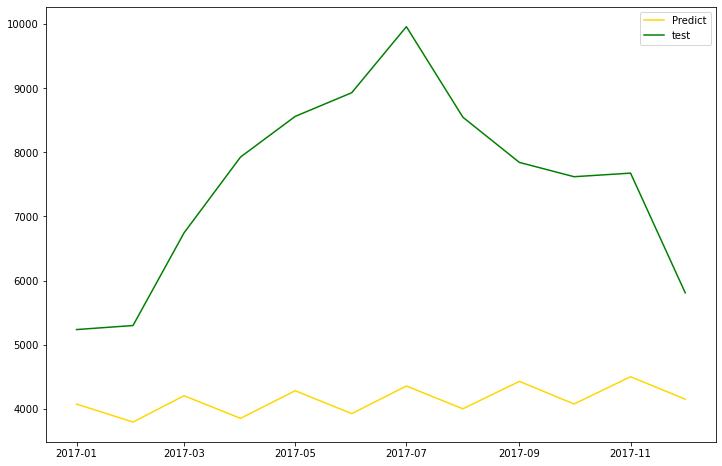

In [15]:
plt.plot(pred_y, color="gold", label='Predict') # 모델이 예상한 가격 그래프
plt.plot(test_y, color="green" , label='test') # 실제 가격 그래프
plt.legend()
plt.show()


In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("r2_score : ", r2_score(test_y, pred_y))
RMSE = mean_squared_error(test_y, pred_y)**0.5
print("RMSE : " , RMSE)


r2_score :  -5.615778286393547
RMSE :  3642.446338871415


In [ ]:
## 5. SARIMA
#  - 데이터가 지닌 계절성까지 고려한 ARIMA 모델이다.
# !pip install pmdarima

In [40]:
from pmdarima import auto_arima

auto_model = auto_arima(training, start_p=0, d=1, start_q=0,
                        max_p=3, max_q=3, 
                        start_P=0, start_Q=0,
                        max_P=3, max_Q=3, m=12,
                        seasonal=True, information_criterion='aic',
                        trace=True)
# AIC가 낮을수록 Best model

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=481.846, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=482.652, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=482.466, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=483.637, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=483.669, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=481.031, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=482.740, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=482.616, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=482.682, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=480.687, Time=0.03 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=482.403, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=48

In [41]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -238.344
Date:                             Fri, 27 Jan 2023   AIC                            480.687
Time:                                     09:59:17   BIC                            483.798
Sample:                                 01-01-2013   HQIC                           481.761
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3185      0.177     -1.801      0.072      -0.665       0.028
sigma2      4.803e+04   1.64e+04      2.924      0.003    1.58e+04    8.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.95   Prob(JB):                         0.56
Heteroskedasticity (H):               1.56   Skew:                            -0.14
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# 학습 데이터셋으로부터 test 데이터 길이만큼 예측
auto_pred_y= pd.DataFrame(auto_model.predict(n_periods=len(test)), 
                          index=test.index) 
auto_pred_y.columns = ['predicted_price']
auto_pred_y


,predicted_price
day,
2017-01-01,5609.43698
2017-02-01,5761.43698
2017-03-01,7225.43698
2017-04-01,8298.43698
2017-05-01,8841.43698
2017-06-01,9452.43698
2017-07-01,10359.43698
2017-08-01,8777.43698
2017-09-01,8068.43698


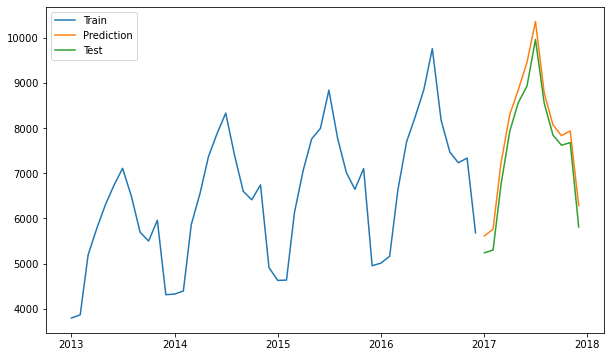

In [20]:
plt.figure(figsize=(10,6))
plt.plot(training, label="Train") # Train 데이터 
plt.plot(auto_pred_y, label="Prediction") # 모델이 예상한 그래프 
plt.plot(test, label="Test") # 실제 가격 그래프 
plt.legend(loc='upper left')
plt.show()


In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("r2_score : ", r2_score(test_y, auto_pred_y))
RMSE = mean_squared_error(test_y, auto_pred_y)**0.5
print("RMSE : " , RMSE)


r2_score :  0.9305467058376857
RMSE :  373.20642840321074
